# Notebook 3 -  Modelagem

# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import statsmodels.api as sm
import pickle

import warnings
pd.options.display.float_format = '{:.2f}'.format
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

# preprocessing
from sklearn.metrics import *
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from feature_engine.imputation import ArbitraryNumberImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer

from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LogisticRegression

from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import SelectByShuffling
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.selection import RecursiveFeatureElimination


from catboost import CatBoostClassifier

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 22000000)
pd.set_option('display.width', 400)
warnings.filterwarnings('ignore')

# Lendo a base

In [2]:
df1 = pd.read_csv("loan_model_base.csv")

In [3]:
df1['prazo'] = df1['prazo'].apply(lambda x: x.strip())

In [4]:
print(df1.shape)
df1.head()

(862074, 36)


,id,volume_emp,prazo,taxa_juros,score,sub_score,nome_emprego,anos_emprego,casa_propria,renda_anual,status_verificacao,mes_inic_emp,status_emp,proposito_emp,titulo_emp,estado_endereco,razao_pag_inc,primeira_linha_cred,linhas_cred_abertas,reg_pub_depreciativos,saldo_rot_total,taxa_uso_linha_rot,status_init,tipo_emp,linhas_abertas_m6,prest_abertas,prest_abertas_m12,razao_saldo_lim_cred,negociacoes_abertas_m12,qtd_consultas_cred,qtd_negociacoes_cred,qtd_consultas_cred_m12,meses_primeira_abert_prestacoes,qtd_hipotecas,emprego_categoria,fico_score
0,68407277,3600.00,36 months,13.99,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,2015-12-01,0,debt_consolidation,Debt consolidation,PA,5.91,2003,7.00,0.00,2765.00,29.70,w,Individual,2.00,2.00,0.00,36.00,3.00,3.00,1.00,4.00,148.00,1.00,gerencia_diretoria,677.00
1,68355089,24700.00,36 months,11.99,C,C1,engineer,10+ years,MORTGAGE,65000.00,Not Verified,2015-12-01,0,small_business,Business,SD,16.06,1999,22.00,0.00,21470.00,19.20,w,Individual,1.00,1.00,0.00,73.00,2.00,0.00,0.00,6.00,113.00,4.00,engenharia,717.00
2,68341763,20000.00,60 months,10.78,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,2015-12-01,0,home_improvement,NaN,IL,10.78,2000,6.00,0.00,7869.00,56.20,w,Joint App,0.00,1.00,0.00,73.00,0.00,2.00,5.00,1.00,125.00,5.00,autonomo,697.00
3,68476807,10400.00,60 months,22.45,F,F1,contract specialist,3 years,MORTGAGE,104433.00,Source Verified,2015-12-01,0,major_purchase,Major purchase,PA,25.37,1998,12.00,0.00,21929.00,64.50,w,Individual,1.00,3.00,0.00,84.00,4.00,2.00,1.00,3.00,128.00,6.00,area_tecnica,697.00
4,68426831,11950.00,36 months,13.44,C,C3,veterinary tecnician,4 years,RENT,34000.00,Source Verified,2015-12-01,0,debt_consolidation,Debt consolidation,GA,10.20,1987,5.00,0.00,8822.00,68.40,w,Individual,0.00,1.00,0.00,99.00,0.00,0.00,0.00,0.00,338.00,0.00,outro,692.00


# Quebra de treino e teste

In [5]:
df2 = df1.copy()

In [6]:
train = df2.query('mes_inic_emp <= "2017-12-01"').copy()
test = df2.query('mes_inic_emp > "2017-12-01"').copy()

In [7]:
df2.drop(['mes_inic_emp', 'nome_emprego'], axis=1, inplace=True)

In [8]:
train.shape

(805756, 36)

In [9]:
test.shape

(56318, 36)

In [10]:
# Utilizando as seguintes variáveis:
target = 'status_emp'

cat_vars = [
    'prazo',
     'score',
     'sub_score',
     'emprego_categoria',
     'anos_emprego',
     'casa_propria',
     'status_verificacao',
     #'mes_inic_emp',
     'proposito_emp',
     #'titulo_emp',
     'estado_endereco',
     'status_init',
     'tipo_emp'
]

num_vars = [
    #'id',
     'volume_emp',
     'taxa_juros',
     'renda_anual',
     'razao_pag_inc',
     'primeira_linha_cred',
     'linhas_cred_abertas',
     'reg_pub_depreciativos',
     'saldo_rot_total',
     'taxa_uso_linha_rot',
     'linhas_abertas_m6',
     'prest_abertas',
     'prest_abertas_m12',
     'razao_saldo_lim_cred',
     'negociacoes_abertas_m12',
     'qtd_consultas_cred',
     'qtd_negociacoes_cred',
     'qtd_consultas_cred_m12',
     'meses_primeira_abert_prestacoes',
     'qtd_hipotecas',
     'fico_score'
]

features = num_vars + cat_vars

In [11]:
# filtrando as colunas com as features
df_train = train[features]

# filtrando o target
y_train = train[target]

In [12]:
# Base teste
df_test = test[features]

# filtrando o target
y_test = test[target]

# Definindo o Pipeline de DataPrep

In [13]:
dataprep_pipe = Pipeline(steps=[
                ('numeric_imputer', MeanMedianImputer( variables = num_vars, imputation_method = 'mean' ) ), 
                ('numeric_scaler', SklearnTransformerWrapper(variables = num_vars, transformer = StandardScaler() ) ), 
                ('categoric_imputer', CategoricalImputer( variables = cat_vars, fill_value = 'missing' ) ), 
                ('one_hot_encoder', OneHotEncoder( variables = cat_vars, drop_last=True) )
])

X_train = dataprep_pipe.fit_transform(df_train)
X_test = dataprep_pipe.transform(df_test)

# Modelos

- Regressão Logística
- Árvore de decisão
- Random Forest
- Catboost

# 1 - Regressão Logística

Usarei duas bibliotecas diferentes, do sklearn e do statsmodels

## 1.1 - SKLEARN

### I. Modelo

In [14]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42)

### II. Validação cruzada

In [15]:
skf = StratifiedKFold(
        n_splits=5, 
        shuffle=False
)

cv_results_lr = cross_validate(
        estimator = lr_model, 
        X = X_train,
        y = y_train, 
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
        cv = skf, 
        n_jobs = -1
)


#salvando resultados
lr_model_results = pd.DataFrame(cv_results_lr)

### III. Resultados

In [16]:
lr_model_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,104.73,1.57,0.67,0.37,0.68,0.48,0.74
1,100.54,1.90,0.65,0.35,0.70,0.47,0.73
2,98.55,3.35,0.65,0.34,0.66,0.45,0.71
3,101.80,1.31,0.66,0.36,0.68,0.47,0.73
4,25.06,0.66,0.62,0.33,0.68,0.44,0.70


In [17]:
accuracy = lr_model_results.mean().loc['test_accuracy']
precision = lr_model_results.mean().loc['test_precision']
recall = lr_model_results.mean().loc['test_recall']
f1 = lr_model_results.mean().loc['test_f1']
roc_auc = lr_model_results.mean().loc['test_roc_auc']

In [18]:
# criando uma tabela vazia que irá conter os resultados dos modelos
df_metrics = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [],'roc_auc': []}

In [19]:
# populando a tabela com os resultados da regressão logística
df_metrics['model'].append('Logistic Regression')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

In [20]:
pd.DataFrame(df_metrics)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.65,0.35,0.68,0.46,0.72


### IV. Comparando a performance no teste

In [21]:
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [22]:
y_pred_test_lr = lr_model.predict_proba(X_test)[:,1]
y_pred_train_lr = lr_model.predict_proba(X_train)[:,1]

print('ROC AUC on train: {}'.format(roc_auc_score(y_train, y_pred_train_lr)))
print('ROC AUC on test: {}'.format(roc_auc_score(y_test, y_pred_test_lr)))

ROC AUC on train: 0.7250765976546647
ROC AUC on test: 0.708622446824466


### 1.2 -  STATSMODELS

### I. Modelo

In [23]:
log_reg = sm.Logit(
    y_train, 
    sm.add_constant( 
        X_train
    )
).fit()

print(log_reg.summary())

         Current function value: 0.469871
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             status_emp   No. Observations:               805756
Model:                          Logit   Df Residuals:                   805605
Method:                           MLE   Df Model:                          150
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.1069
Time:                        20:33:00   Log-Likelihood:            -3.7860e+05
converged:                      False   LL-Null:                   -4.2393e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -28.4512   6915.199     -0.004      0.997   -1.36e

In [24]:
keep_vals = log_reg.pvalues[log_reg.pvalues <= 0.05].index.tolist()

In [25]:
log_reg2 = sm.Logit(
    y_train, 
    sm.add_constant( 
        X_train[keep_vals]
    )
).fit()

print(log_reg2.summary())

Optimization terminated successfully.
         Current function value: 0.473124
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             status_emp   No. Observations:               805756
Model:                          Logit   Df Residuals:                   805674
Method:                           MLE   Df Model:                           81
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                  0.1007
Time:                        20:33:19   Log-Likelihood:            -3.8122e+05
converged:                       True   LL-Null:                   -4.2393e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.7778      

### II. Comparando performance de treino e teste

In [26]:
# performing predictions on the test set
y_prob_train_lr = log_reg2.predict(sm.add_constant( X_train[keep_vals] ) )
y_prob_test_lr = log_reg2.predict(sm.add_constant( X_test[keep_vals] ) )

y_pred_train_lr = np.where(y_prob_train_lr >= 0.5, 1, 0)
y_pred_test_lr = np.where(y_prob_test_lr >= 0.5, 1, 0)
  
print('AUC on train: {}'.format(roc_auc_score(y_train, y_prob_train_lr)))
print('AUC on test: {}'.format(roc_auc_score(y_test, y_prob_test_lr)))
print('_'*50)
print('Precision on train: {}'.format(precision_score(y_train, y_pred_train_lr)))
print('Precision on test: {}'.format(precision_score(y_test, y_pred_test_lr)))
print('_'*50)
print('Recall on train: {}'.format(recall_score(y_train, y_pred_train_lr)))
print('Recall on test: {}'.format(recall_score(y_test, y_pred_test_lr)))
print('_'*50)
print('Accuracy on train: {}'.format(accuracy_score(y_train, y_pred_train_lr)))
print('Accuracy on test: {}'.format(accuracy_score(y_test, y_pred_test_lr)))

AUC on train: 0.7213039770967521
AUC on test: 0.69721706662386
__________________________________________________
Precision on train: 0.5453122365917684
Precision on test: 0.3704710144927536
__________________________________________________
Recall on train: 0.1280951761358172
Recall on test: 0.13826910074374577
__________________________________________________
Accuracy on train: 0.7852898396040489
Accuracy on test: 0.8271955680244327


In [27]:
# populando a tabela com os resultados da regressão logística
df_metrics['model'].append('Logistic Regression SM')
df_metrics['accuracy'].append(accuracy_score(y_train, y_pred_train_lr))
df_metrics['precision'].append(precision_score(y_train, y_pred_train_lr))
df_metrics['recall'].append(recall_score(y_train, y_pred_train_lr))
df_metrics['f1'].append(f1_score(y_train, y_pred_train_lr))
df_metrics['roc_auc'].append(roc_auc_score(y_train, y_prob_train_lr))

# 2 - Tratamento para árvores

In [28]:
df_train_num = df_train[num_vars]
df_train_cat = df_train[cat_vars]

df_test_num = df_test[num_vars]
df_test_cat = df_test[cat_vars]

In [29]:
# instanciando
mmi = MeanMedianImputer(variables=num_vars, imputation_method='mean') #num
ci = CategoricalImputer(variables = cat_vars, fill_value='missing') #cat
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) #cat

# tratamento numericas
X_train_num = mmi.fit_transform(df_train_num)
X_test_num = mmi.transform(df_test_num)

# tratamento categoricas
X_train_cat = ci.fit_transform(df_train_cat)
X_test_cat = ci.transform(df_test_cat)

X_train_cat.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)
X_train_num.reset_index(drop=True, inplace=True)
X_test_num.reset_index(drop=True, inplace=True)

# obtendo dados pro catb
X_train_catb = pd.concat( [ X_train_num, X_train_cat ], axis=1 )
X_test_catb = pd.concat( [ X_test_num, X_test_cat ], axis=1 )


X_train_cat = oe.fit_transform(X_train_cat)
X_test_cat = oe.transform(X_test_cat)

X_train = pd.concat( [X_train_num, pd.DataFrame(X_train_cat, columns=cat_vars)], axis=1 )
X_test = pd.concat( [X_test_num, pd.DataFrame(X_test_cat, columns=cat_vars)], axis=1 )

# 2.1 - Decision Tree Classifier

### I. Modelo

In [30]:
params_dt = {
    'max_depth': 4, 
    'min_samples_leaf': 100,
    'class_weight': 'balanced',
    'random_state': 0
}

In [31]:
dt_model = DecisionTreeClassifier(**params_dt)

### II. Validação cruzada

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=False)

cv_results_dt = cross_validate(estimator = dt_model,
                               X = X_train, 
                               y = y_train, 
                               scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                               cv = skf, 
                               n_jobs = -1
                              )

dt_model_results = pd.DataFrame(cv_results_dt)

### III. Resultados

In [33]:
dt_model_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,16.74,0.60,0.70,0.38,0.58,0.46,0.72
1,16.61,0.63,0.65,0.35,0.66,0.45,0.71
2,15.95,0.60,0.61,0.32,0.67,0.43,0.68
3,16.42,0.63,0.66,0.35,0.66,0.46,0.71
4,6.32,0.27,0.59,0.31,0.68,0.42,0.67


In [34]:
accuracy = dt_model_results.mean().loc['test_accuracy']
precision = dt_model_results.mean().loc['test_precision']
recall = dt_model_results.mean().loc['test_recall']
f1 = dt_model_results.mean().loc['test_f1']
roc_auc = dt_model_results.mean().loc['test_roc_auc']

In [35]:
# populando a tabela com os resultados da regressão logística
df_metrics['model'].append('Decision Tree')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

### IV. Comparando performance no conjunt de teste

In [36]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100, random_state=0)

In [37]:
y_prob_test_dt = dt_model.predict_proba(X_test)[:,1]
y_prob_train_dt = dt_model.predict_proba(X_train)[:,1]

# performing predictions on the test set
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

  
print('AUC on train: {}'.format(roc_auc_score(y_train, y_prob_train_dt)))
print('AUC on test: {}'.format(roc_auc_score(y_test, y_prob_test_dt)))
print('_'*50)
print('Precision on train: {}'.format(precision_score(y_train, y_pred_train_dt)))
print('Precision on test: {}'.format(precision_score(y_test, y_pred_test_dt)))
print('_'*50)
print('Recall on train: {}'.format(recall_score(y_train, y_pred_train_dt)))
print('Recall on test: {}'.format(recall_score(y_test, y_pred_test_dt)))
print('_'*50)
print('Accuracy on train: {}'.format(accuracy_score(y_train, y_pred_train_dt)))
print('Accuracy on test: {}'.format(accuracy_score(y_test, y_pred_test_dt)))

AUC on train: 0.7029856579171593
AUC on test: 0.6776382483700414
__________________________________________________
Precision on train: 0.3360978532144997
Precision on test: 0.23135870177679277
__________________________________________________
Recall on train: 0.6696611924171367
Recall on test: 0.6940500338066261
__________________________________________________
Accuracy on train: 0.6373343791420728
Accuracy on test: 0.5884619482225931


### V. Visualizando a DT

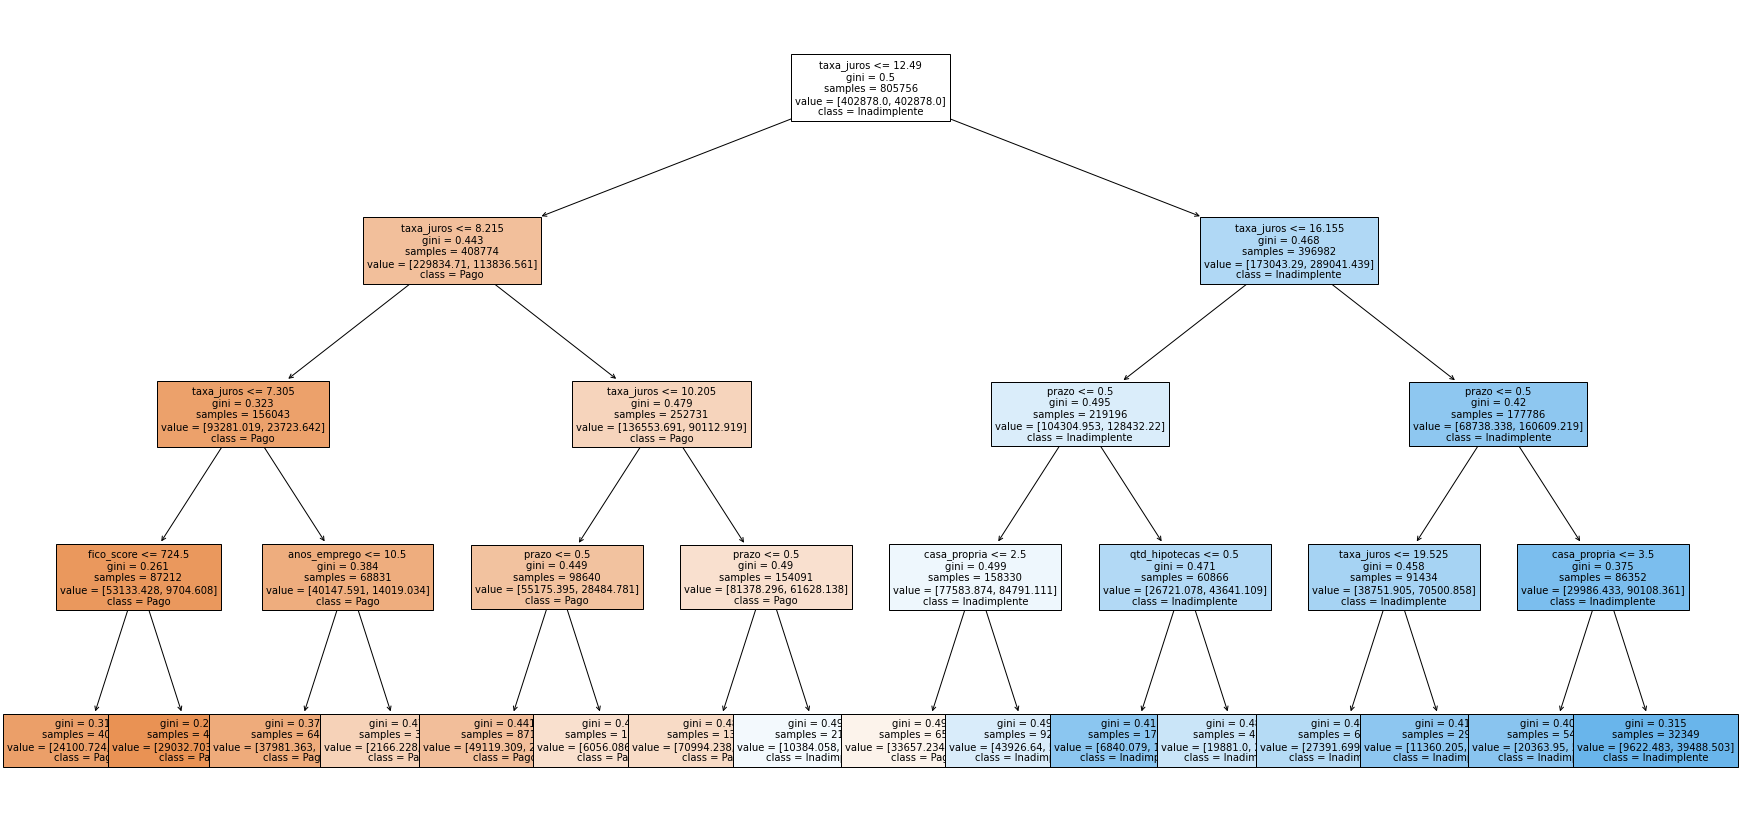

In [38]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,15))

plot_tree(
    dt_model,
    feature_names = X_train.columns.tolist(), 
    class_names = ['Pago', 'Inadimplente'],
    filled = True,
    fontsize=10
);

fig.savefig('imagename.png')

# 2.2 - Random Forest

### I. Modelo

In [39]:
params_rf = {
    'max_depth': 4, 
    'min_samples_leaf': 100,
    'n_estimators': 100,
    'class_weight': 'balanced',
    'random_state': 0
}

In [40]:
rf_model =  RandomForestClassifier( **params_rf )

### II. Validação cruzada 

In [41]:
skf = StratifiedKFold(
        n_splits=5, 
        shuffle=False
)

cv_results_rf = cross_validate(
                    estimator = rf_model,
                    X = X_train, 
                    y = y_train, 
                    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                    cv = skf, 
                    n_jobs = -1
)

rf_model_results = pd.DataFrame(cv_results_rf)

### III. Resultados

In [42]:
rf_model_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,189.78,3.34,0.66,0.35,0.69,0.47,0.73
1,190.21,3.29,0.61,0.33,0.74,0.45,0.72
2,181.56,5.15,0.58,0.31,0.73,0.43,0.69
3,177.21,6.06,0.62,0.33,0.73,0.46,0.72
4,85.39,2.44,0.55,0.29,0.75,0.42,0.68


In [43]:
accuracy = rf_model_results.mean().loc['test_accuracy']
precision = rf_model_results.mean().loc['test_precision']
recall = rf_model_results.mean().loc['test_recall']
f1 = rf_model_results.mean().loc['test_f1']
roc_auc = rf_model_results.mean().loc['test_roc_auc']

In [44]:
# populando a tabela com os resultados da random forest
df_metrics['model'].append('Random Forest')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

### IV. Comparando performance no conjunt de teste

In [45]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100, random_state=0)

In [46]:
y_prob_test_rf = rf_model.predict_proba(X_test)[:,1]
y_prob_train_rf = rf_model.predict_proba(X_train)[:,1]

# performing predictions on the test set
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

  
print('AUC on train: {}'.format(roc_auc_score(y_train, y_prob_train_rf)))
print('AUC on test: {}'.format(roc_auc_score(y_test, y_prob_test_rf)))
print('_'*50)
print('Precision on train: {}'.format(precision_score(y_train, y_pred_train_rf)))
print('Precision on test: {}'.format(precision_score(y_test, y_pred_test_rf)))
print('_'*50)
print('Recall on train: {}'.format(recall_score(y_train, y_pred_train_rf)))
print('Recall on test: {}'.format(recall_score(y_test, y_pred_test_rf)))
print('_'*50)
print('Accuracy on train: {}'.format(accuracy_score(y_train, y_pred_train_rf)))
print('Accuracy on test: {}'.format(accuracy_score(y_test, y_pred_test_rf)))

AUC on train: 0.7134519628656014
AUC on test: 0.6919777022579763
__________________________________________________
Precision on train: 0.32125908497253325
Precision on test: 0.22966077332183413
__________________________________________________
Recall on train: 0.7291689059609543
Recall on test: 0.7201938246562993
__________________________________________________
Accuracy on train: 0.602617914107993
Accuracy on test: 0.575269008132391


# 2.3 - CatBoost

In [47]:
#X_train_catb = df_train[features]
y_train_catb = y_train

#X_test_catb = df_test[features]
y_test_catb = y_test

### I. Modelo

In [48]:
params_catb = {
    'objective': 'Logloss',
    #'colsample_bylevel': 0.01,
    'depth': 4,
    #'boosting_type': 'Plain',
    #'bootstrap_type': 'Bernoulli',
    'iterations': 200,
    #'learning_rate': 0.05,
    #'l2_leaf_reg': 20,
    #'border_count': 23,
    #'subsample': 0.5,
    'cat_features': cat_vars,
    #'use_best_model': True,
    'random_state': 0

}

In [49]:
catb_model =  CatBoostClassifier( **params_catb )

### II. Validação cruzada 

In [50]:
skf = StratifiedKFold(
        n_splits=5, 
        shuffle=False
)

cv_results_catb = cross_validate(
                    estimator = catb_model,
                    X = X_train_catb, 
                    y = y_train_catb, 
                    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                    cv = skf, 
                    n_jobs = -1
)

catb_model_results = pd.DataFrame(cv_results_catb)

In [51]:
cv_results_catb

{'fit_time': array([522.711169  , 531.30872798, 530.48517585, 528.08155894,
        130.21055508]),
 'score_time': array([10.6378231 ,  4.72727418,  4.57063818,  4.54639626,  1.56436777]),
 'test_accuracy': array([0.79103579, 0.78752847, 0.77822043, 0.78920391, 0.78029302]),
 'test_precision': array([0.6419273 , 0.57004405, 0.47933796, 0.56802755, 0.49815498]),
 'test_recall': array([0.10739945, 0.12810794, 0.12697649, 0.16332419, 0.1985631 ]),
 'test_f1': array([0.18401221, 0.20920135, 0.20076927, 0.25370183, 0.28394612]),
 'test_roc_auc': array([0.74642498, 0.70692988, 0.716671  , 0.73591383, 0.71275269])}

### III. Resultados

In [52]:
catb_model_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,522.71,10.64,0.79,0.64,0.11,0.18,0.75
1,531.31,4.73,0.79,0.57,0.13,0.21,0.71
2,530.49,4.57,0.78,0.48,0.13,0.20,0.72
3,528.08,4.55,0.79,0.57,0.16,0.25,0.74
4,130.21,1.56,0.78,0.50,0.20,0.28,0.71


In [53]:
accuracy = catb_model_results.mean().loc['test_accuracy']
precision = catb_model_results.mean().loc['test_precision']
recall = catb_model_results.mean().loc['test_recall']
f1 = catb_model_results.mean().loc['test_f1']
roc_auc = catb_model_results.mean().loc['test_roc_auc']

In [54]:
# populando a tabela com os resultados da catboost
df_metrics['model'].append('CatBoost')
df_metrics['accuracy'].append(accuracy)
df_metrics['precision'].append(precision)
df_metrics['recall'].append(recall)
df_metrics['f1'].append(f1)
df_metrics['roc_auc'].append(roc_auc)

### IV. Comparando performance no conjunt de teste

In [55]:
catb_model.fit(X_train_catb, y_train_catb)

Learning rate set to 0.5
0:	learn: 0.5269668	total: 899ms	remaining: 2m 58s
1:	learn: 0.4916848	total: 1.72s	remaining: 2m 50s
2:	learn: 0.4822570	total: 2.48s	remaining: 2m 43s
3:	learn: 0.4767536	total: 3.17s	remaining: 2m 35s
4:	learn: 0.4744194	total: 3.92s	remaining: 2m 33s
5:	learn: 0.4731404	total: 4.44s	remaining: 2m 23s
6:	learn: 0.4721272	total: 5.13s	remaining: 2m 21s
7:	learn: 0.4713958	total: 5.83s	remaining: 2m 19s
8:	learn: 0.4706723	total: 6.64s	remaining: 2m 20s
9:	learn: 0.4700851	total: 7.27s	remaining: 2m 18s
10:	learn: 0.4698444	total: 8s	remaining: 2m 17s
11:	learn: 0.4695699	total: 8.68s	remaining: 2m 16s
12:	learn: 0.4693687	total: 9.42s	remaining: 2m 15s
13:	learn: 0.4692139	total: 10.2s	remaining: 2m 15s
14:	learn: 0.4689335	total: 10.9s	remaining: 2m 14s
15:	learn: 0.4685819	total: 11.6s	remaining: 2m 13s
16:	learn: 0.4684386	total: 12.4s	remaining: 2m 13s
17:	learn: 0.4682069	total: 13.2s	remaining: 2m 13s
18:	learn: 0.4680893	total: 13.9s	remaining: 2m 12s


157:	learn: 0.4605413	total: 1m 53s	remaining: 30.2s
158:	learn: 0.4605331	total: 1m 54s	remaining: 29.5s
159:	learn: 0.4605147	total: 1m 55s	remaining: 28.8s
160:	learn: 0.4604789	total: 1m 55s	remaining: 28s
161:	learn: 0.4604770	total: 1m 56s	remaining: 27.3s
162:	learn: 0.4604456	total: 1m 57s	remaining: 26.6s
163:	learn: 0.4604352	total: 1m 57s	remaining: 25.9s
164:	learn: 0.4604271	total: 1m 58s	remaining: 25.1s
165:	learn: 0.4604004	total: 1m 59s	remaining: 24.4s
166:	learn: 0.4603891	total: 1m 59s	remaining: 23.7s
167:	learn: 0.4603548	total: 2m	remaining: 23s
168:	learn: 0.4603339	total: 2m 1s	remaining: 22.3s
169:	learn: 0.4603146	total: 2m 2s	remaining: 21.6s
170:	learn: 0.4602838	total: 2m 2s	remaining: 20.8s
171:	learn: 0.4602722	total: 2m 3s	remaining: 20.1s
172:	learn: 0.4602449	total: 2m 4s	remaining: 19.4s
173:	learn: 0.4602191	total: 2m 4s	remaining: 18.7s
174:	learn: 0.4602138	total: 2m 5s	remaining: 17.9s
175:	learn: 0.4601985	total: 2m 6s	remaining: 17.2s
176:	lear

In [56]:
y_prob_test_catb = catb_model.predict_proba(X_test_catb)[:,1]
y_prob_train_catb = catb_model.predict_proba(X_train_catb)[:,1]

# pecatborming predictions on the test set
y_pred_train_catb = catb_model.predict(X_train_catb)
y_pred_test_catb = catb_model.predict(X_test_catb)

  
print('AUC on train: {}'.format(roc_auc_score(y_train_catb, y_prob_train_catb)))
print('AUC on test: {}'.format(roc_auc_score(y_test_catb, y_prob_test_catb)))
print('_'*50)
print('Precision on train: {}'.format(precision_score(y_train_catb, y_pred_train_catb)))
print('Precision on test: {}'.format(precision_score(y_test_catb, y_pred_test_catb)))
print('_'*50)
print('Recall on train: {}'.format(recall_score(y_train_catb, y_pred_train_catb)))
print('Recall on test: {}'.format(recall_score(y_test_catb, y_pred_test_catb)))
print('_'*50)
print('Accuracy on train: {}'.format(accuracy_score(y_train_catb, y_pred_train_catb)))
print('Accuracy on test: {}'.format(accuracy_score(y_test_catb, y_pred_test_catb)))

AUC on train: 0.7422042127683935
AUC on test: 0.7340509215595257
__________________________________________________
Precision on train: 0.5974534769833496
Precision on test: 0.4503441494591937
__________________________________________________
Recall on train: 0.1552891659642354
Recall on test: 0.1548343475321163
__________________________________________________
Accuracy on train: 0.7917334776284632
Accuracy on test: 0.8370503213892538


# VENDO RESULTADOS FINAIS

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

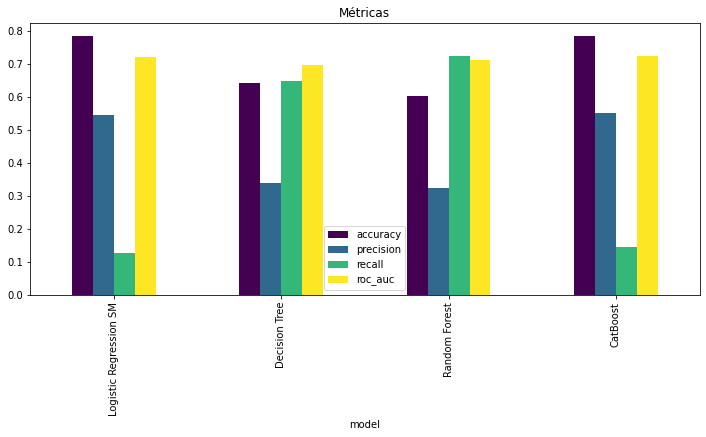

In [58]:
df_de_metricas = pd.DataFrame(df_metrics)

df_de_metricas.drop(0, axis=0).set_index('model')[[
    'accuracy',
    'precision',
    'recall',
    'roc_auc'
]].plot(kind='bar', colormap='icefire', figsize=(12,5))

plt.title("Métricas")
plt.legend(loc='best')
#plt.legend('best')

In [97]:
df_de_metricas

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.65,0.35,0.68,0.46,0.72
1,Logistic Regression SM,0.79,0.55,0.13,0.21,0.72
2,Decision Tree,0.64,0.34,0.65,0.44,0.70
3,Random Forest,0.60,0.32,0.73,0.45,0.71
4,CatBoost,0.79,0.55,0.14,0.23,0.72


# Feature Selection

In [59]:
# fs_pipe = Pipeline([
#     ('constant', DropConstantFeatures(tol=0.998)), 
#     ('duplicated', DropDuplicateFeatures()),
# #     ('shuffle', SelectByShuffling(estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1),
# #                                   scoring="roc_auc", 
# #                                   cv=3)
# #     ),
# #     ('rfe': RecursiveFeatureElimination(
# #         estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1),
# #         scoring="roc_auc",
# #         cv=3,
# #         threshold = 0.04)
# #     ),
#     ('smart_corr', SmartCorrelatedSelection(
#         variables=None, # usa todas as variáveis
#         method="pearson", # método de correlação
#         threshold=0.7, # threshold
#         missing_values="ignore",
#         selection_method="model_performance", # forma de selecionar as features
#         estimator=RandomForestClassifier(n_estimators=10, random_state=1))
#     )
# ])

# fs_pipe.fit(X_train, y_train)

In [60]:
# X_train_fs = fs_pipe.transform(X_train)

In [61]:
# X_train.shape

In [62]:
# X_train_fs.shape

In [63]:
# type(X_train_fs)

# Grid Seach do melhor modelo

Otimizando recall devido reducao do falso negativo


$$ precision = \frac{TP}{TP + FP} $$


$$ recall = \frac{TP}{TP + FN} $$


In [66]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=0)

grid_parametros = {
    'max_depth': [3, 4],
    'max_features': ['auto'],
    'min_samples_leaf': [25, 50, 100],
    #'min_samples_split': [50, 100],
    'n_estimators': [200],
    'class_weight': ['balanced']
}


grid_search = GridSearchCV(
    estimator = rf_model, 
    param_grid = grid_parametros, 
    scoring = 'recall', 
    cv = 3, 
    n_jobs = -1, 
    #refit = True, 
    verbose = 2
)

In [67]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': ['auto'],
                         'min_samples_leaf': [25, 50, 100],
                         'min_samples_split': [50, 100],
                         'n_estimators': [200]},
             scoring='recall', verbose=2)

In [68]:
# retorna a melhor combinação de hiperparâmetros
best_params = grid_search.best_params_
best_params

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 25,
 'min_samples_split': 50,
 'n_estimators': 200}

In [69]:
# retorna o melhor score, nesse caso a roc-auc média usando um cv=5
best_score = grid_search.best_score_
best_score

0.010669470427910712

In [70]:
# retorna o melhor modelo do grid
best_rf_model = grid_search.best_estimator_

## Avaliando a performance na base out of time

In [93]:
best_model = RandomForestClassifier(**best_params, **{'random_state': 0, 'class_weight': 'balanced'})
best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=25, min_samples_split=50,
                       n_estimators=200, random_state=0)

In [94]:
y_prob_test_best_rf = best_model.predict_proba(X_test)[:,1]
y_prob_train_best_rf = best_model.predict_proba(X_train)[:,1]

# pebest_rforming predictions on the test set
y_pred_train_best_rf = best_model.predict(X_train)
y_pred_test_best_rf = best_model.predict(X_test)

  
print('AUC on train: {}'.format(roc_auc_score(y_train, y_prob_train_best_rf)))
print('AUC on test: {}'.format(roc_auc_score(y_test, y_prob_test_best_rf)))
print('_'*50)
print('Precision on train: {}'.format(precision_score(y_train, y_pred_train_best_rf)))
print('Precision on test: {}'.format(precision_score(y_test, y_pred_test_best_rf)))
print('_'*50)
print('Recall on train: {}'.format(recall_score(y_train, y_pred_train_best_rf)))
print('Recall on test: {}'.format(recall_score(y_test, y_pred_test_best_rf)))
print('_'*50)
print('Accuracy on train: {}'.format(accuracy_score(y_train, y_pred_train_best_rf)))
print('Accuracy on test: {}'.format(accuracy_score(y_test, y_pred_test_best_rf)))

AUC on train: 0.7144671576360851
AUC on test: 0.6931531364061022
__________________________________________________
Precision on train: 0.3264878360779539
Precision on test: 0.23232840626372017
__________________________________________________
Recall on train: 0.719048238641828
Recall on test: 0.7155735857561415
__________________________________________________
Accuracy on train: 0.6129523081429118
Accuracy on test: 0.5826201214531767


# Salvando modelo e dados

In [96]:
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [89]:
X_train.to_csv('X_train.csv', index=None)
X_test.to_csv('X_test.csv', index=None)
y_train.to_csv('y_train.csv', index=None)
y_test.to_csv('y_test.csv', index=None)

# FIM